# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import math
import ntpath
import os
import time
import pickle

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from skimage.feature import hog

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage.measurements import label

%matplotlib inline


### Bounding Boxes Drawing

In [2]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # A function that takes an image, a list of bounding boxes, 
    # and optional color tuple and line thickness as inputs
    # then draws boxes in that color on the output    
    
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    #print(bboxes[0])
    for i in range(len(bboxes)):
        cv2.rectangle(draw_img, bboxes[i][0],bboxes[i][1], color, thick)
        
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

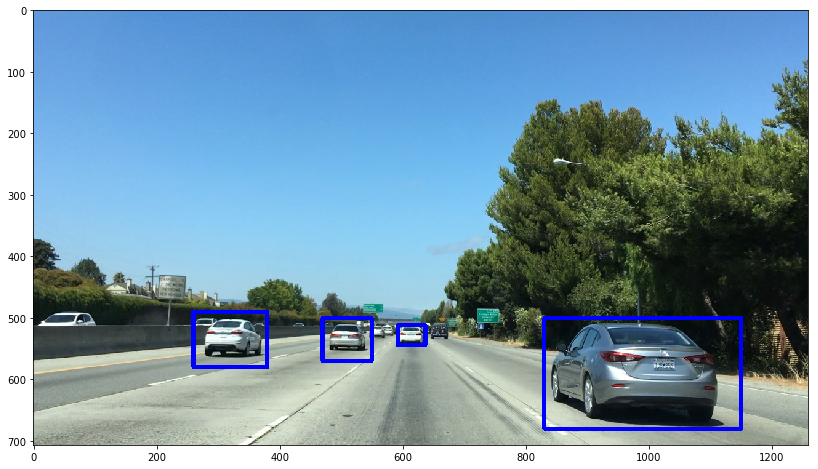

In [3]:
freeway_img = mpimg.imread('./examples/freeway.jpg')

# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((830, 500), (1150, 680)), 
      ((260, 490), (380, 580)), 
      ((470, 500),(550,570)),
      ((592,512),(637,544))]

result = draw_boxes(freeway_img, bboxes)
fig = plt.figure(figsize=(18,8))
plt.imshow(result)

### Data Exploration

cars len:  8792
notcars len:  8968
data_look() function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


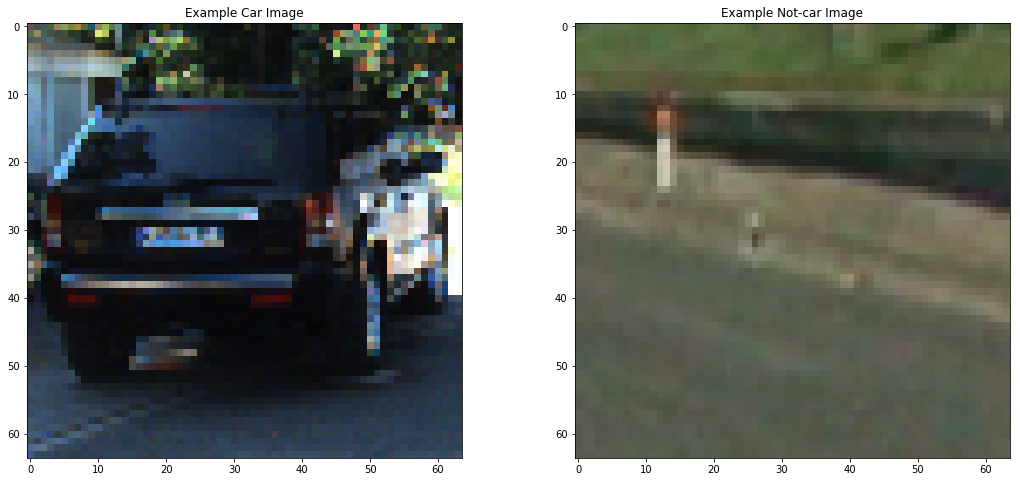

In [4]:
# Function that get lists of image file names for 'car' and 'not car' from data directory
def get_car_n_not_car_lists():
    images = glob.glob('./data/vehicles_no_vehicles_smallset/*.jpeg')
    cars = []
    notcars = []

    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)

    return cars, notcars

def get_car_n_not_car_lists_2():

    cars = glob.glob('./data/vehicles/**/*.png')
    noncars = glob.glob('./data/non-vehicles/**/*.png')
    
    return cars, noncars


# Function that take two lists of image file name/path and return dictionary with characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = (0, 0, 0)
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = None
    
    if len(car_list) > 0:
        img = mpimg.imread(car_list[0])
        data_dict["image_shape"]  = img.shape
        data_dict["data_type"] = img.dtype
    
    # Return data_dict
    return data_dict


#cars, notcars = get_car_n_not_car_lists()
cars, notcars = get_car_n_not_car_lists_2()

print('cars len: ', len(cars))
print('notcars len: ', len(notcars))
        
data_info = data_look(cars, notcars)

print('data_look() function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


### Color Histogram

In [5]:
# Function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), return_features_only=True):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    if return_features_only:
        
        return hist_features
    
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

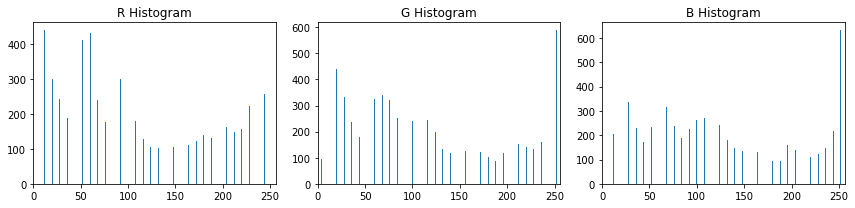

In [6]:
image = mpimg.imread('./examples/cutout1.jpg')
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256), return_features_only=False )

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('color_hist() function is returning None for at least one variable...')

### Spatial Binning of Color

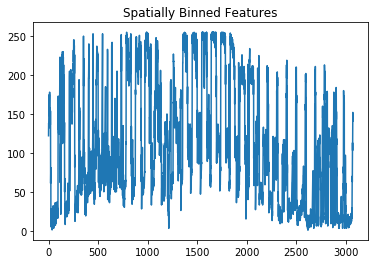

In [7]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)    
    
    features =  cv2.resize(feature_image, size).ravel() # Remove this line!
    # Return the feature vector
    return features
 
image = mpimg.imread('./examples/cutout1.jpg')
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

### HOG Features Extraction

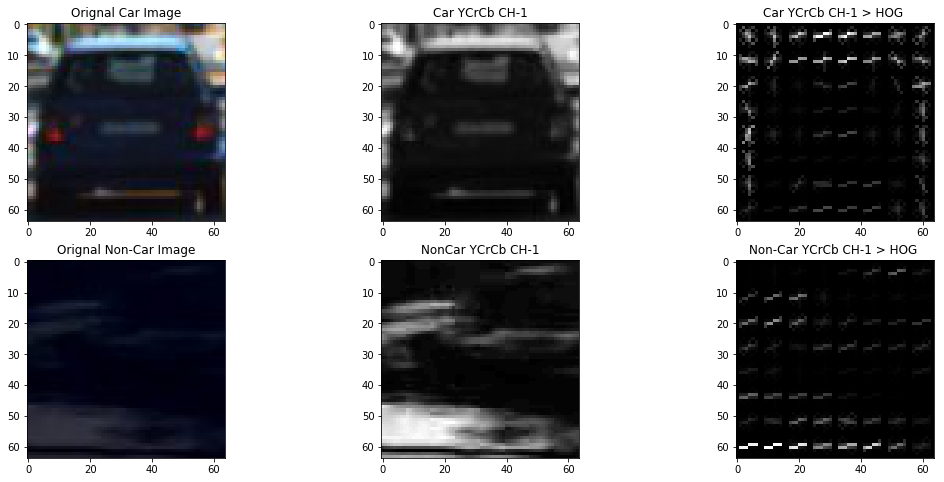

In [8]:
# Function to return HOG features and/or visualization of a gray image
def get_hog_features_v1(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, 
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=True, 
                                  feature_vector=feature_vec)
        
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, 
                      orientations=orient, 
                      pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), 
                      visualise=False, 
                      feature_vector=feature_vec)
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

cars, notcars = get_car_n_not_car_lists()

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

# Read in the image
car_image = mpimg.imread(cars[ind])
car_image_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
car_image_YCrCb = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
car_image_YCrCb_ch1 = car_image_YCrCb[:,:,0]

noncar_image = mpimg.imread(notcars[ind])
noncar_image_gray = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2GRAY)
noncar_image_YCrCb = cv2.cvtColor(noncar_image, cv2.COLOR_RGB2YCrCb)
noncar_image_YCrCb_ch1 = noncar_image_YCrCb[:,:,0]

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
"""
car_hog_features, car_hog_image = get_hog_features(car_image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

noncar_hog_features, noncar_hog_image = get_hog_features(noncar_image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

"""
car_hog_features, car_hog_image = get_hog_features(car_image_YCrCb_ch1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

noncar_hog_features, noncar_hog_image = get_hog_features(noncar_image_YCrCb_ch1, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure(figsize=(18,8))
plt.subplot(231)
plt.imshow(car_image, cmap='gray')
plt.title('Orignal Car Image')

plt.subplot(232)
plt.imshow(car_image_YCrCb_ch1, cmap='gray')
plt.title('Car YCrCb CH-1')

plt.subplot(233)
plt.imshow(car_hog_image, cmap='gray')
plt.title('Car YCrCb CH-1 > HOG ')


plt.subplot(234)
plt.imshow(noncar_image, cmap='gray')
plt.title('Orignal Non-Car Image')

plt.subplot(235)
plt.imshow(noncar_image_YCrCb_ch1, cmap='gray')
plt.title('NonCar YCrCb CH-1')

plt.subplot(236)
plt.imshow(noncar_hog_image, cmap='gray')
plt.title('Non-Car YCrCb CH-1 > HOG ')

### Combine and Normalize Features

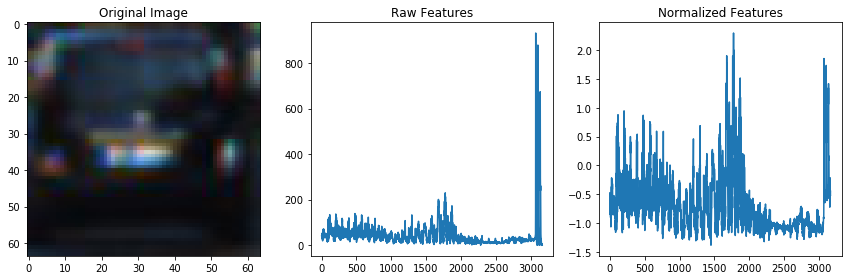

In [9]:
# Function to extract features from a list of images
# This function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        
    for imgfile in imgs:
        """
        filename, file_ext = os.path.splitext(imgfile)
        
        if file_ext == '.png':     
            image = cv2.imread(imgfile)
        else:
            image = mpimg.imread(imgfile)        
        """
   
        image = mpimg.imread(imgfile)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)   
        
        # Apply bin_spatial() to get spatial color features
        spatial_feature_vec = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() to get color histogram features
        color_histogram_feature_vec = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_feature_vec, color_histogram_feature_vec)))
        
    # Return list of feature vectors
    return features


def extract_features_hog(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    
    file_ext = '';
    
    if len(imgs) > 0:
        filename, file_ext = os.path.splitext(imgs[0])
    
    # Iterate through the list of images
        # Read in each one by one
        # apply color conversion if other than 'RGB'
        
    for imgfile in imgs:
        """
        if file_ext == '.png':     
            image = cv2.imread(imgfile)
        else:
            image = mpimg.imread(imgfile)        
        """
        
        image = mpimg.imread(imgfile)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)   
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    # Return list of feature vectors
    return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial(),  color_hist(), and get_hog_features()
def extract_features_all(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    file_ext = '';
    
    if len(imgs) > 0:
        filename, file_ext = os.path.splitext(imgs[0])
    

    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        # if file_ext == '.png':     
        #    image = cv2.imread(file)
        # else:
        #   image = mpimg.imread(file)
        
        image = mpimg.imread(file)  
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


cars, notcars = get_car_n_not_car_lists()

car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('extract_features() function only returns empty feature vectors...')

### Color Classify

In [10]:
# Get list of  car and non-car images
cars, notcars = get_car_n_not_car_lists()

# Paramters to play with to see  the classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

# Extract features
car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial, 'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()

svc.fit(X_train, y_train)

t2 = time.time()

print(round(t2-t,), ' Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test),4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these ', n_predict, ' labels: ', y_test[0:n_predict])

t2 = time.time()
print(round(t2-t, 5),  ' Seconds to predict', n_predict, ' labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
3  Seconds to train SVC...
Test Accuracy of SVC =  0.9828
My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  0.  0.  1.]
For these  10  labels:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  1.]
0.00953  Seconds to predict 10  labels with SVC


### HOG Classify

In [11]:
# Get list of  car and non-car images
cars, notcars = get_car_n_not_car_lists()

# Tweak these parameters and see how the results change
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 
pixel_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()

# Extract features
car_features = extract_features_hog(cars, 
                                       cspace=colorspace, 
                                       orient=orient, 
                                       pix_per_cell=pixel_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)

notcar_features = extract_features_hog(notcars,  
                                       cspace=colorspace, 
                                       orient=orient, 
                                       pix_per_cell=pixel_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel)

t2 = time.time()

print(round(t2-t, 2), ' Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)) ,np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0,100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2),' Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test),3))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



10.78  Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
0.4  Seconds to train SVC...
Test Accuracy of SVC =  0.991
My SVC predicts:  [ 0.  1.  1.  0.  0.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  0.  1.  0.  0.  1.]
0.01103 Seconds to predict 10 labels with SVC


## Sliding Window Implementation

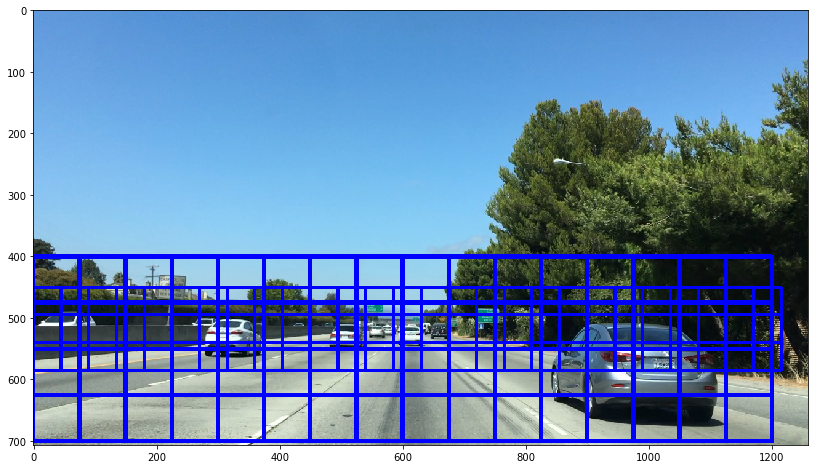

In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
        
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
        
        
    # Return the list of windows
    return window_list

image = mpimg.imread('./examples/freeway.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
                    xy_window=(150, 150), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)   

windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[450, 600], 
                    xy_window=(90, 90), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(window_img, windows2, color=(0, 0, 255), thick=3)   
         
#window_img = draw_boxes(image, windows_list, color=(0, 0, 255), thick=6)   
fig = plt.figure(figsize=(18,8))
plt.imshow(window_img)

### Search and Classify

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
5.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9899


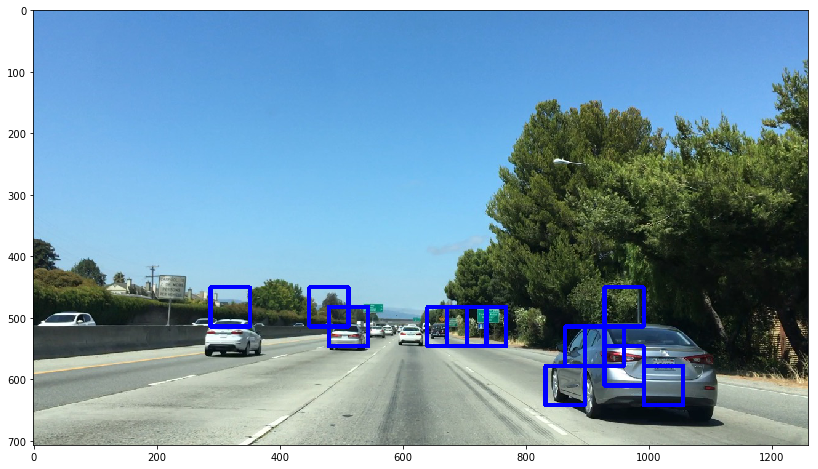

In [13]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
#cars, notcars = get_car_n_not_car_lists()
cars, notcars = get_car_n_not_car_lists_2()

### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, 700] # Min and max in y to search in slide_window()

car_features = extract_features_all(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features_all(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('./examples/freeway.jpg')
#image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

fig = plt.figure(figsize=(18,8))
plt.imshow(window_img)

### Hog Sub-sampling Window Search

In [14]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    found_box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                ybox_top = np.int(ytop*scale)
                win_length = np.int(window*scale)
                box = ((xbox_left, ybox_top+ystart),(xbox_left+win_length,ybox_top+win_length+ystart))
                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                
                found_box_list.append(box)
                
    if draw == True:
        draw_img, found_box_list
    else:
        return found_box_list
    
    
    
def find_cars_2(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image  
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec =False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec =False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [15]:
# Read in cars and notcars
#cars, notcars = get_car_n_not_car_lists()
cars, notcars = get_car_n_not_car_lists_2()

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True #True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

"""
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True #True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
                                    
                        
car_features = extract_features_all(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features_all(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
"""

car_features = []
for car in cars:
    img = mpimg.imread(car)
    feature = single_img_features(img, color_space=color_space, spatial_size = spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    car_features.append(feature)
    
notcar_features = []
for noncar in notcars:
    img = mpimg.imread(noncar)
    feature = single_img_features(img, color_space=color_space, spatial_size = spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
    notcar_features.append(feature)   

    
    
print('car_features len: ', len(car_features))
print('notcar_features len: ', len(notcar_features))


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)


# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


svc_pickle_data = {}
svc_pickle_data['color_space'] = color_space
svc_pickle_data['orient'] = orient
svc_pickle_data['pix_per_cell'] = pix_per_cell
svc_pickle_data['cell_per_block'] = cell_per_block
svc_pickle_data['hog_channel'] = hog_channel
svc_pickle_data['spatial_size'] = spatial_size
svc_pickle_data['hist_bins'] = hist_bins
svc_pickle_data['spatial_feat'] = spatial_feat
svc_pickle_data['hist_feat'] = hist_feat
svc_pickle_data['hog_feat'] = hog_feat
svc_pickle_data['y_start_stop'] = y_start_stop
svc_pickle_data['X_scaler'] = X_scaler
svc_pickle_data['svc'] = svc

pickle.dump(svc_pickle_data, open('svc_pickle.p', 'wb'))

print('svc_pickle_data saved')



car_features len:  8792
notcar_features len:  8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
24.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
svc_pickle_data saved


In [16]:
def load_saved_svc_data_dictionary():
    return pickle.load(open('svc_pickle.p','rb'))

run time is: 1.3556022644042969


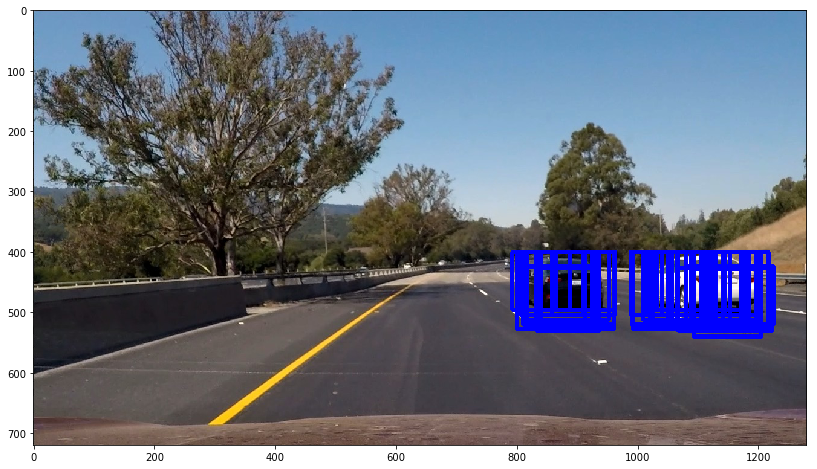

In [17]:
y_start_stop = [400, 656]
scale = 1.2
heat_thresh = 1
scale_range = [1.5, 2]
scale_steps = 5

t = time.time()
detected = []

#test_img = mpimg.imread('./examples/freeway1.jpg')
#test_img = mpimg.imread('./examples/freeway.jpg')
#test_img = mpimg.imread('./test_images/test3.jpg')
#test_img = mpimg.imread('./test_images/test5.jpg')
test_img = mpimg.imread('./test_images/test6.jpg')

for scale in np.linspace(scale_range[0], scale_range[1], scale_steps):
    boxes = find_cars(test_img, y_start_stop[0], y_start_stop[1], 
                            scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins, draw = False)

    if len(boxes) != 0:
        detected.append(boxes)

if len(detected) > 0:
    detected = np.concatenate(detected)

print ('run time is: '+ str(time.time() - t))


out_img = np.copy(test_img)
for box in detected:
    cv2.rectangle(out_img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0,0,255), 6)

fig = plt.figure(figsize=(18,8))
plt.imshow(out_img)


### Multiple Detections & False Positives

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

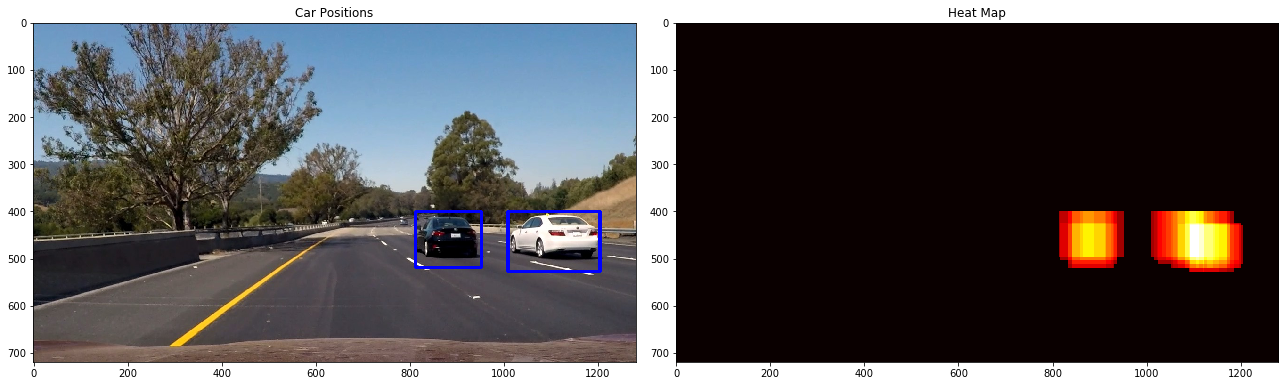

In [19]:
#box_list = found_box_list
box_list = detected

# Read in image similar to one shown above 
#image = mpimg.imread('./examples/freeway1.jpg')
#image = mpimg.imread('./examples/freeway.jpg')
#image = mpimg.imread('./test_images/test3.jpg')
#image = mpimg.imread('./test_images/test5.jpg')
image = mpimg.imread('./test_images/test6.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(18,8))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


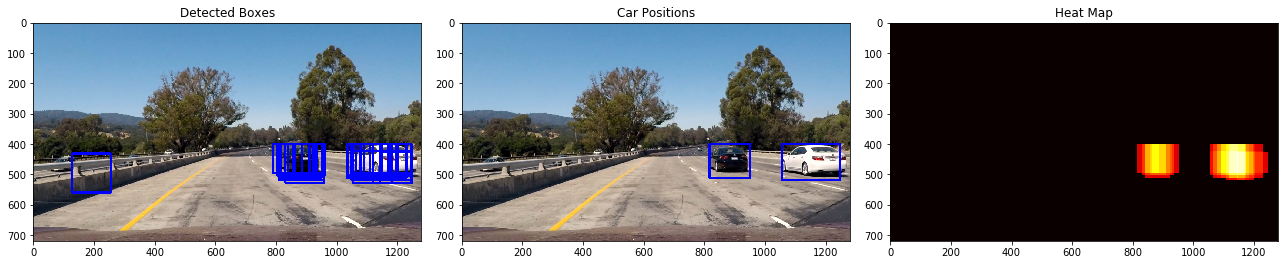

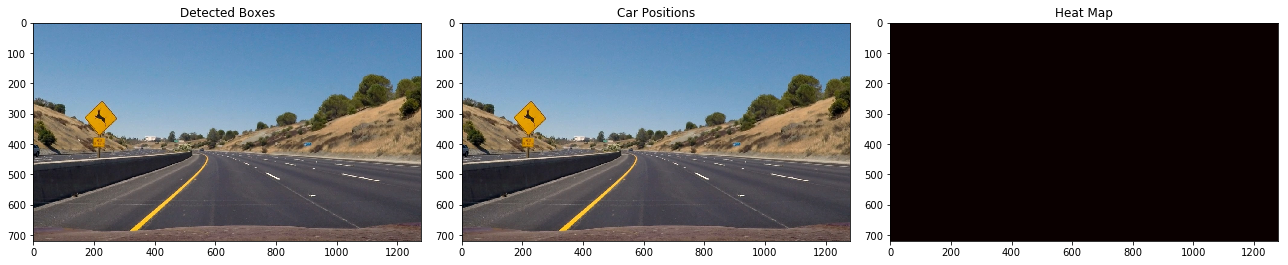

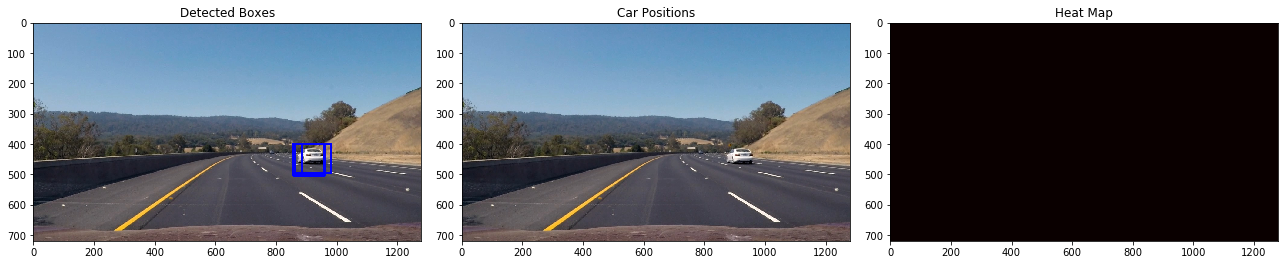

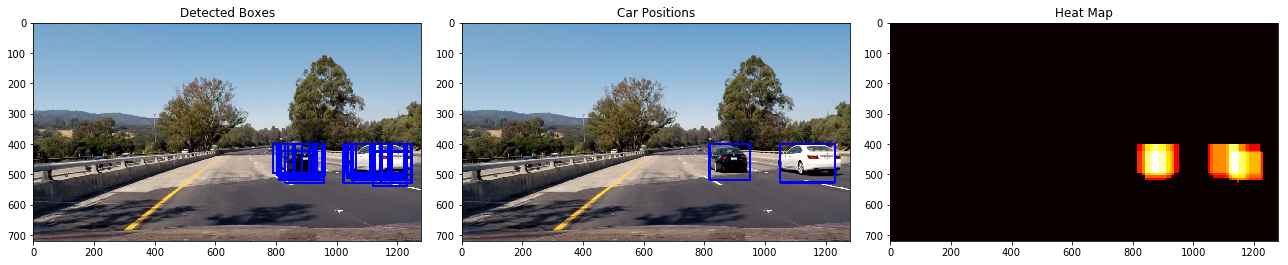

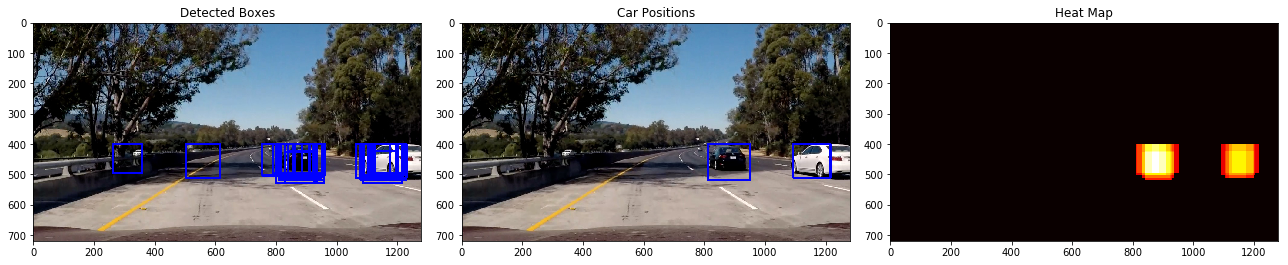

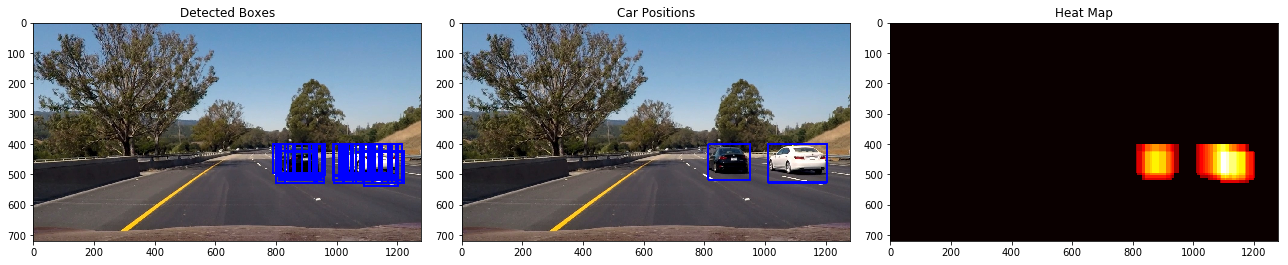

In [20]:
# load trained svc classifier and related paramters
svc_data_dict = load_saved_svc_data_dictionary()

svc = svc_data_dict["svc"]
X_scaler = svc_data_dict["X_scaler"]
orient = svc_data_dict["orient"]
pix_per_cell = svc_data_dict["pix_per_cell"]
cell_per_block = svc_data_dict["cell_per_block"]
spatial_size = svc_data_dict["spatial_size"]
hist_bins = svc_data_dict["hist_bins"]

y_start_stop = [400, 656]
scale = 1.2
heat_thresh = 1
scale_range = [1.5, 2]
scale_steps = 5

test_images = glob.glob('test_images/test*.jpg')

for image_path in test_images:
    
    # Read image
    src_image = mpimg.imread(image_path)
    
    detected_boxes = []
    
    for scale in np.linspace(scale_range[0], scale_range[1], scale_steps):
        boxes = find_cars(src_image, y_start_stop[0], y_start_stop[1], 
                                scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins, draw = False)

        if len(boxes) != 0:
            detected_boxes.append(boxes)

    if len(detected_boxes) > 0:
        detected_boxes = np.concatenate(detected_boxes)

        
    detected_boxes_img = np.copy(src_image)
    
    for box in detected_boxes:
        cv2.rectangle(detected_boxes_img, (box[0][0], box[0][1]), (box[1][0], box[1][1]), (0,0,255), 6)
    
    
    heat = np.zeros_like(src_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,detected_boxes)

    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,1)
    heat = apply_threshold(heat,4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    car_positions_img = draw_labeled_bboxes(np.copy(src_image), labels)

    fig = plt.figure(figsize=(18,8))
   
    plt.subplot(131)
    plt.imshow(detected_boxes_img)
    plt.title('Detected Boxes')
    
    plt.subplot(132)
    plt.imshow(car_positions_img)
    plt.title('Car Positions')
    
    plt.subplot(133)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
    fig.tight_layout()

In [21]:
from collections import deque
b_boxes_deque = deque(maxlen=30)

def add_heat_video(heatmap, b_boxes_deque):
    # Iterate through list of bboxes
    for bbox_list in b_boxes_deque:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

# load trained svc classifier and related paramters
svc_data_dict = load_saved_svc_data_dictionary()

svc = svc_data_dict["svc"]
X_scaler = svc_data_dict["X_scaler"]
orient = svc_data_dict["orient"]
pix_per_cell = svc_data_dict["pix_per_cell"]
cell_per_block = svc_data_dict["cell_per_block"]
spatial_size = svc_data_dict["spatial_size"]
hist_bins = svc_data_dict["hist_bins"]

y_start_stop = [400, 656]
scale = 1.5
heat_thresh = 1
scale_range = [1.5, 2]
scale_steps = 5

video_frame_counter = 0

prev_processed_image = None

def process_video_image(src_image):
    
    global video_frame_counter
    global prev_processed_image
    
    video_frame_counter += 1
    
    if video_frame_counter > 3:
        video_frame_counter = 0
        return prev_processed_image
    
    detected_boxes = []
    
    """
    boxes = find_cars(src_image, y_start_stop[0], y_start_stop[1], 
                            scale, svc, X_scaler, orient, pix_per_cell, 
                            cell_per_block, spatial_size, hist_bins, draw = False)  
    """
                               
    for scale in np.linspace(scale_range[0], scale_range[1], scale_steps):
        boxes = find_cars(src_image, y_start_stop[0], y_start_stop[1], 
                                scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins, draw = False)

        if len(boxes) != 0:
            detected_boxes.append(boxes) 
            b_boxes_deque.append(boxes)
            
    # b_boxes_deque.append(boxes)
    
    # if len(boxes) != 0:
    #    detected_boxes.append(boxes)
        

    if len(detected_boxes) > 0:
        detected_boxes = np.concatenate(detected_boxes)

    heat = np.zeros_like(src_image[:,:,0]).astype(np.float)
    

    # Add heat to each box in box list
    #heat = add_heat(heat,detected_boxes)
    
    heat = add_heat_video(heat, b_boxes_deque)
    
    # Apply threshold to help remove false positives
    #heat = apply_threshold(heat,1)
    heat = apply_threshold(heat,7)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    car_positions_img = draw_labeled_bboxes(np.copy(src_image), labels)
    
    prev_processed_image = car_positions_img
    
    return car_positions_img

In [28]:
videos_output_dir = 'videos_output'
if not os.path.isdir(videos_output_dir):
    os.makedirs(videos_output_dir)

video_output = videos_output_dir + '/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")

#output_clip = clip1.fl_image(visualize_street_lines_on_image) #NOTE: this function expects color images!!
output_clip = clip1.fl_image(process_video_image)
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video videos_output/project_video.mp4
[MoviePy] Writing video videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:35<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_video.mp4 

Wall time: 21min 36s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))